# Customer Segmentation Project

Companies must understand their customers in order to launch successful marketing campaigns, develop popular new products, and increase revenue. 

One way to analyze customer traits is through k-means clustering, an unsupervised machine learning algorithm that organizes customers into segments by minimizing the distances between data points within those segments (which can be defined by data features chosen by the analyst).

In this project, I explore customer data (from __[Kaggle](https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign/data)__) and then employ k-means clustering to create customer segments. In business practice, these customer segments could inform targeted marketing or product development strategies, or perhaps even serve as the basis for further consumer research to gather additional data.

## About the data

This dataset contains consumer data for a B2C company, including consumer birthdate, marital status, education level, spending total, and more. We'll begin by importing and cleaning the data.

In [1]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Read in data
df = pd.read_csv("data/market.csv", sep=";")

To narrow the scope of this project, we will sum all of the spending data into one single column. We'll also convert the birthdate column to age and clean up other columns in a similar fashion.

In [2]:
df['total_spent'] = df['MntWines']+df['MntFruits']+df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']+df['MntGoldProds']
df['age'] = df['Year_Birth'].apply(lambda x : datetime.now().year - x)
df['education_level'] = df['Education'].replace({'Basic':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate', '2n Cycle':'Postgraduate'})
df['number_of_children'] = df['Kidhome'] + df['Teenhome']
df['marital_status'] = df['Marital_Status'].replace({'Together':'Married', 'Divorced':'Single', 'Widow':'Single', 'Alone':'Single', 'Absurd':'Single', 'YOLO':'Single'})

In [3]:
# Remove any unneeded columns
df = df[['age', 'education_level', 'marital_status', 'number_of_children', 'Income', 'total_spent']]

# For cleanliness, we'll convert all of our column names to lowercase
df.rename(str.lower, axis='columns', inplace=True)

In [4]:
# Examining the data to see how many rows and columns it contains
df.shape

(2240, 6)

In [5]:
# Calculate some descriptive statistics on numerical columns
df.describe()

,age,number_of_children,income,total_spent
count,2240.000000,2240.000000,2216.000000,2240.000000
mean,54.194196,0.950446,52247.251354,605.798214
std,11.984069,0.751803,25173.076661,602.249288
min,27.000000,0.000000,1730.000000,5.000000
25%,46.000000,0.000000,35303.000000,68.750000
50%,53.000000,1.000000,51381.500000,396.000000
75%,64.000000,1.000000,68522.000000,1045.500000
max,130.000000,3.000000,666666.000000,2525.000000


In [6]:
# Take a look at a sample of the data
df.head(3)

,age,education_level,marital_status,number_of_children,income,total_spent
0,66,Graduate,Single,0,58138.0,1617
1,69,Graduate,Single,2,46344.0,27
2,58,Graduate,Married,0,71613.0,776


We can already see from the descriptive statistics above that there are some outliers in our consumers' incomes. We'll visualize this distribution in a histogram.

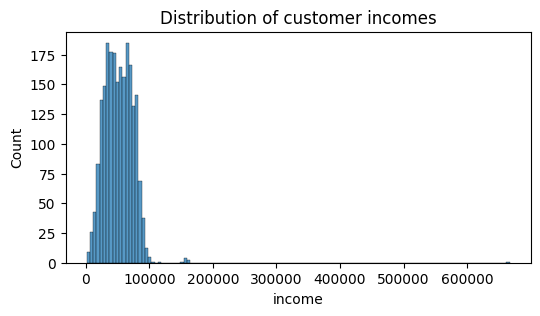

In [7]:
plt.figure(figsize=(6, 3))

sns.histplot(data=df, x="income")
plt.title("Distribution of customer incomes");

As part of our data exploration, we can use a scatter plot to examine the relationship between total spending, education level, and income.

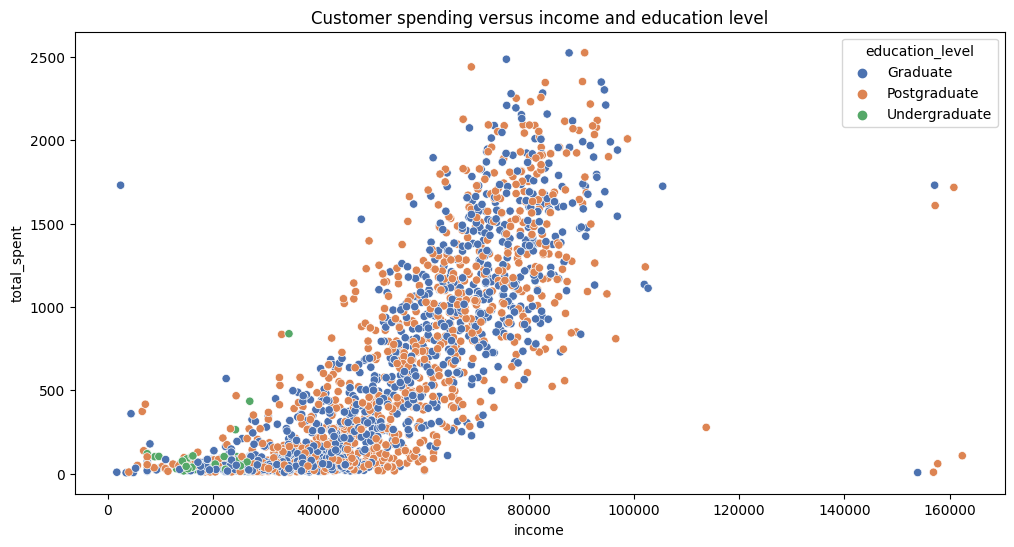

In [8]:
plt.figure(figsize=(12, 6))

df_without_outliers = df.loc[df['income']<600000]

sns.scatterplot(data=df_without_outliers, x="income", y="total_spent", hue="education_level", palette="deep")
plt.title("Customer spending versus income and education level");

From the scatter plot, we can see that total spending and income are _positively_ correlated. We can also see that, as one might expect, customers with an undergraduate education level tend to be lower income and spend less on this company's products.

We can extend our exploratory data analysis by creating a correlation matrix and heatmap. This allows us to easily discern any other variable relationships within our numerical data.

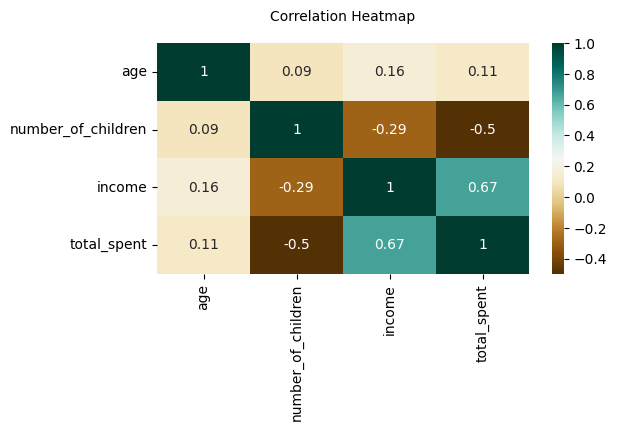

In [9]:
plt.figure(figsize=(6, 3))

heatmap = sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':10}, pad=16);

The strongest correlation within our data is the positive correlation between income and total amount spent. It appears that there is also a weak negative correlation between the number of children a consumer has and how much they spend.

## K-Means Clustering

Now, we'll prepare our data for k-means clustering. We can create customer clusters based on any attributes that we desire. For simplicity's sake, I'll create customer segments based on age, income, and amount spent.

In [10]:
# First, drop any null values.
df.dropna(subset=['age', 'income', 'total_spent'],inplace=True)

In [11]:
# Take only the columns we want to cluster by
data = df[['age', 'income', 'total_spent']] 

# Unskew the data with a log transformation
df_log = np.log(data)

# Norm/standardize the data (k-means clustering works best when data has the same variance)
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df_log)

In [12]:
# Find the optimal number of clusters 
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=13)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

from kneed import KneeLocator
kl = KneeLocator(x = range(1, 11),
                 y = wcss,
                 curve="convex",
                 direction="decreasing")

# Print out the optimal number of clusters
print(kl.elbow)

3


In [13]:
# Since we now know the optimal number of clusters (3), we can fit our data to this model again
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=13)
kmeans.fit(df_scaled)

data = data.assign(cluster=kmeans.labels_)

Finally, we can examine the average attributes of our 3 customer clusters/segments to discern, qualitatively, what type of customer defines each segment.

In [14]:
result = data.groupby("cluster").agg({"age":"mean", "income":"median", "total_spent":"median"}).reset_index()
result

,cluster,age,income,total_spent
0,0,65.681347,62853.0,833.0
1,1,49.940071,31626.0,55.0
2,2,45.290051,67432.0,1001.0


#### From the chart above, we can understand our 3 customer segments as follows:

- Customers in __cluster 0__ are old, have a high income, and spend a lot of money on the company's products.
- Customers in __cluster 1__ are young, have a small income, and spend small amounts of money on the company's products.
- Customers in __cluster 2__ are young, have a high income, and spend a lot of money on the company's products.

These clearly-defined customer segments can inform business decisions to help optimize marketing strategy and develop more relevant products.

### Limitations

1. We did not explore the categorical values in this dataset as deeply as the numerical ones. One can utilize one-hot encoding to map categorical values to numerical values for fur

### Reference
1. https://s3.amazonaws.com/assets.datacamp.com/production/course_10628/slides/chapter3.pdf
2. https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign/data